# Performances of matrix multiplication on tapered fat trees

In [1]:
library(ggplot2)

plot_results <- function(global_results, local_results){

    communication_times <- local_results[,c("nb_roots", "communication_time")]
    colnames(communication_times) <- c("nb_roots", "time")
    communication_times$group <- "communication"
    computation_times <- local_results[,c("nb_roots", "computation_time")]
    colnames(computation_times) <- c("nb_roots", "time")
    computation_times$group <- "computation"
    global_times <- global_results[,c("nb_roots", "time")]
    global_times$group <- "total"

    all_times = rbind(communication_times, computation_times, global_times)
    
    size <- global_results['size'][1,]
    nb_proc <- global_results['nb_proc'][1,]
    
    title <- paste("Time to perform a matrix product on tapered fat trees\nMatrix size:", size, "\nNumber of processes: ", nb_proc, "\n")
    return(ggplot(all_times, aes(x=nb_roots, y=time, group=group, col=group, fill=group))+
        stat_summary(geom="line", fun.y=mean)+
        stat_summary(fun.data = mean_sdl, geom = "errorbar")+
   #     stat_summary(geom="point", fun.y=mean)+
        expand_limits(x=0, y=0)+
        ggtitle(title)
    )
}

We compute a matrix product.

The topology is a 2-level fat-tree made with 48 port switches, where we remove some of the root switches.
In other word, we use fat-trees (2;24,48;1,n;1,1) for n in [1, 24].

The goal with such an experiment is to see if we can make some economies (by removing switches) without losing in performances. This is a similar idea to what was done in the paper “Characterizing Parallel Scientific Applicatioon Commodity Clusters: An Empirical Study of a Tapered Fat-Tre”.

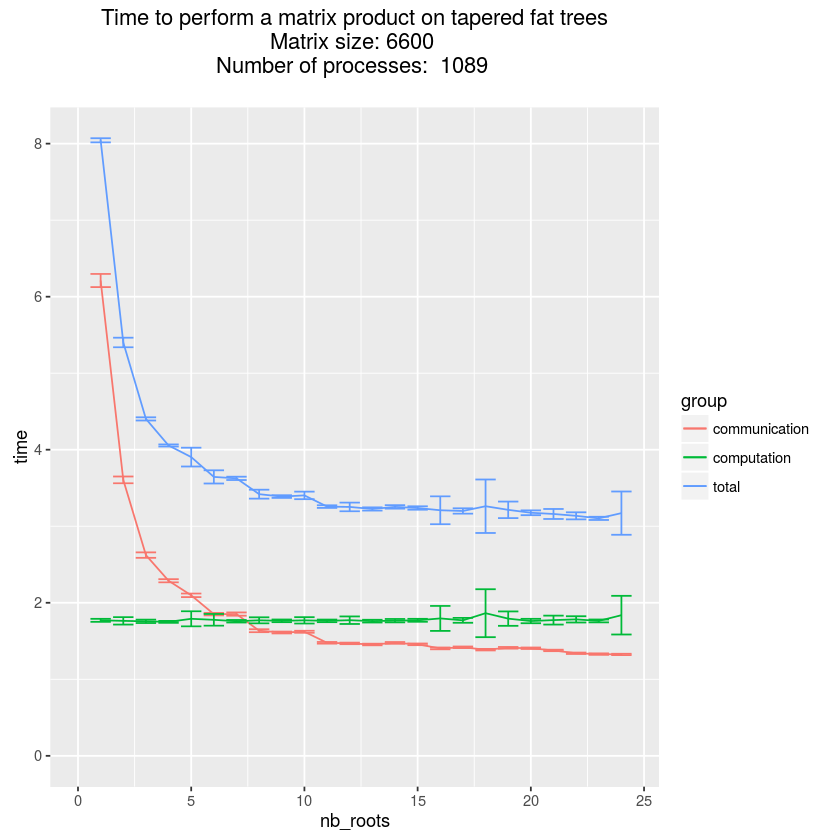

In [2]:
local_results <- read.csv("local_1089.csv")
global_results <- read.csv("global_1089.csv")
plot_results(global_results, local_results)

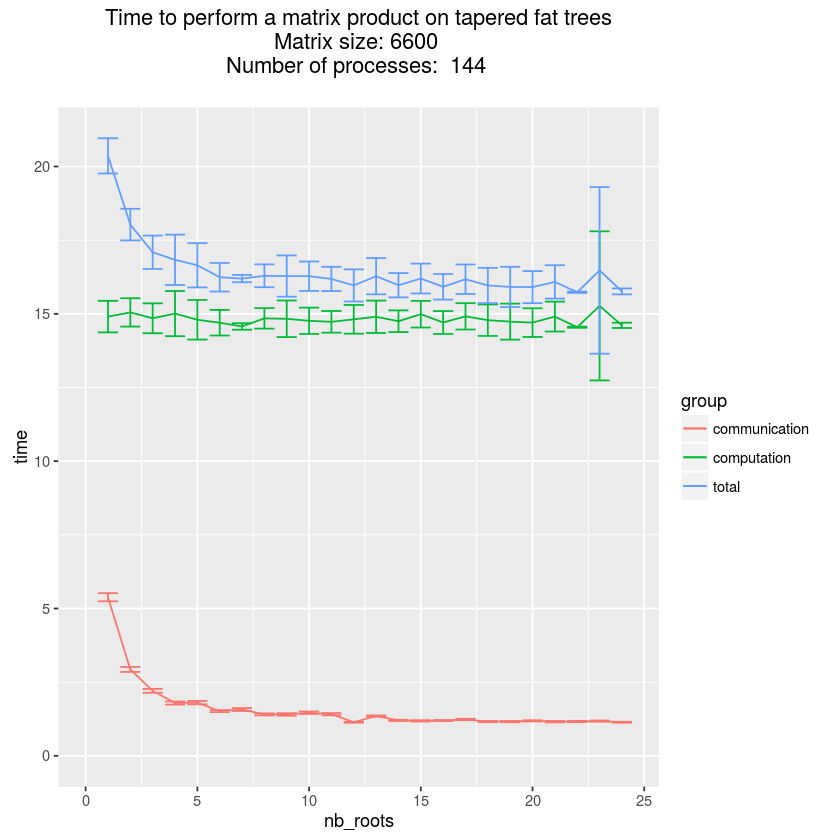

In [3]:
local_results <- read.csv("local_144.csv")
global_results <- read.csv("global_144.csv")
plot_results(global_results, local_results)

There seems to have some outliers in the first plot. We should:

  * Find if these outliers can be explained. Maybe the simulation was perturbated by another application?
  * Do more experiments to have smaller confidence intervals.

In [4]:
global_results <- read.csv("global_1089.csv")
global_results[global_results['nb_roots'] == 15,]

,fat_tree,nb_roots,nb_proc,size,time
10,"2;24,48;1,15;1,1",15,1089,6600,3.229717
36,"2;24,48;1,15;1,1",15,1089,6600,3.254485
60,"2;24,48;1,15;1,1",15,1089,6600,3.240314
94,"2;24,48;1,15;1,1",15,1089,6600,3.226434
97,"2;24,48;1,15;1,1",15,1089,6600,3.241045


In [5]:
global_results[global_results['nb_roots'] == 24,]

,fat_tree,nb_roots,nb_proc,size,time
13,"2;24,48;1,24;1,1",24,1089,6600,3.085621
45,"2;24,48;1,24;1,1",24,1089,6600,3.113377
59,"2;24,48;1,24;1,1",24,1089,6600,3.420973
87,"2;24,48;1,24;1,1",24,1089,6600,3.144620
104,"2;24,48;1,24;1,1",24,1089,6600,3.092826


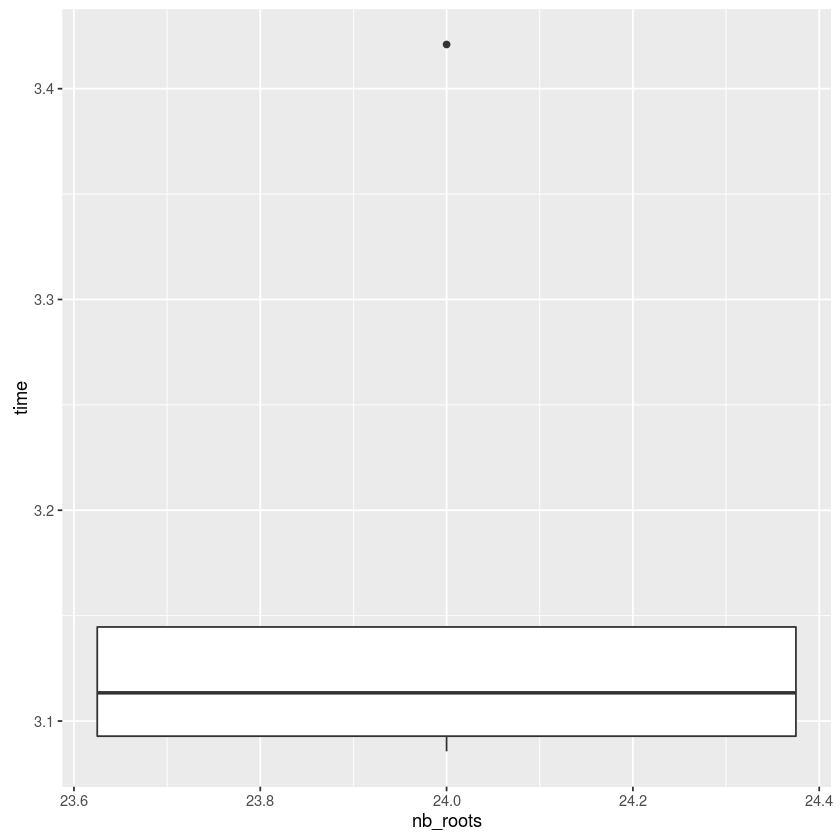

In [6]:
res <- global_results[global_results['nb_roots'] == 24,]
ggplot(res, aes(nb_roots, time)) +  geom_boxplot()

In [7]:
global_results <- read.csv("global_144.csv")
global_results[global_results['nb_roots'] == 23,]

,fat_tree,nb_roots,nb_proc,size,time
14,"2;24,48;1,23;1,1",23,144,6600,18.98648
44,"2;24,48;1,23;1,1",23,144,6600,15.74125
59,"2;24,48;1,23;1,1",23,144,6600,15.77837
93,"2;24,48;1,23;1,1",23,144,6600,15.75073
120,"2;24,48;1,23;1,1",23,144,6600,16.11232


Again an outlier. And for a size of 144, there seems to be more variability anyway.